In [1]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_y():
    """Pauli Y matrix."""
    return np.array([[0, -1j], [1j, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds

def icosahedral_bonds_next():
    """
    Defines the next nn connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a next nn bond between spin i and spin j.
    """
    bonds = [
        (0, 3), (0, 6), (0, 7), (0, 10), (0, 11),
        (1, 2), (1, 4), (1, 5), (1, 8), (1, 9),
        (2, 4), (2, 5), (2, 10), (2, 11), (3, 6),
        (3, 7), (3, 8), (3, 9), (4, 6), (4, 9),
        (4, 11), (5, 7), (5, 8), (5, 10), (6, 9),
        (6, 11), (7, 8), (7, 10), (8, 9), (10, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h): #, bonds=None):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Y = csr_matrix(pauli_y())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    #if bonds == "single":
    #    # Get single bonds
    #    bonds = icosahedral_bonds()
    #elif bonds == "double":
    #    # Get next nn bonds
    #    bonds = icosahedral_bonds_next()
    
    # Interaction term: J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in icosahedral_bonds():
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term

    # perturbation term: J/10 * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in icosahedral_bonds_next():
        termx = 1
        termy = 1
        termz = 1
        for k in range(N):
            if k == i or k == j:
                termx = kron(termx, X, format="csr")
                termy = kron(termy, Y, format="csr")
                termz = kron(termz, Z, format="csr")
            else:
                termx = kron(termx, I, format="csr")
                termy = kron(termy, I, format="csr")
                termz = kron(termz, I, format="csr")
        H += J/10 * (termx + termy + termz)
    
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term

    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem_size, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(subsystem_size)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [ ]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

#bonds = "double"  # Use "single" for nearest neighbors, "double" for next nearest neighbors

#keep_qubits = [0, 4]
#keep_qubits = [0, 4, 5, 11] # 4 spins rdm full rank
#keep_qubits = [0, 4, 5, 9]  # 4 spins - 2 adjacent triangular plaquettes - this is when i observe exactly 5 degenerate scars
#keep_qubits = [3, 5, 7, 9, 11]  # 5 spins - 3 adjacent triangular plaquettes
keep_qubits = [0, 4, 5, 9, 11]  # 5 spins - 3 adjacent triangular plaquettes
#keep_qubits = [2, 8, 4, 5, 9] # 5 spins - pentagon around 0



# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h) #, bonds=bonds)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

# Define the C5 permutation mapping for your case - around axis through vert 9 and 10
perm = {
    0: 2,
    2: 7,
    7: 11,
    11: 5,
    5: 0,
    1: 3,
    3: 4,
    4: 8,
    8: 6,
    6: 1,
    9: 9,   # Fixed
    10: 10  # Fixed
}

In [4]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-35.15047442 -31.54841441 -31.54841441 ...  39.1417227   43.94367067
  44.25030868]


In [5]:
##################### RDMS + EE #################################

In [6]:
'''# rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()
    # Check if the rank is not full and print it
    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
    if rank < traced_out_density_matrix_dense.shape[0]:
        print(f"Traced-out density matrix rank: {rank}")
    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
      min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
      rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms# Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')'''

<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
C:\Users\camip\AppData\Local\Temp\ipykernel_12972\734414245.py:45: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(r"$\lambda_{\text{min}}$")


'# rdm - qutip\n\nmin_eigenvalues = []\nmin_rdms = []\nrdm_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n    # Check if the rank is not full and print it\n    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)\n    if rank < traced_out_density_matrix_dense.shape[0]:\n        print(f"Traced-out density matrix rank: {rank}")\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenv

In [7]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np = []
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

100%|██████████| 4096/4096 [15:34<00:00,  4.38it/s]


In [8]:
# Create a dictionary to store arrays of min_rdms_np for each unique non-full rank value
min_rdms_by_rank = {}

# Compute the rank for each RDM in min_rdms_np
red_ranks = [np.linalg.matrix_rank(rdm) for rdm in min_rdms_np]

# For each unique non-full rank, collect the corresponding RDMs
for rank in set(red_ranks):
    min_rdms_by_rank[rank] = [rdm for rdm, r in zip(min_rdms_np, red_ranks) if r == rank]

# Now min_rdms_by_rank[rank] is a list of RDMs with that rank
for rank, rdms in min_rdms_by_rank.items():
    print(f"Rank {rank}: {len(rdms)} RDMs")

Indices of non-full-rank points: []
Indices for each non-full rank:


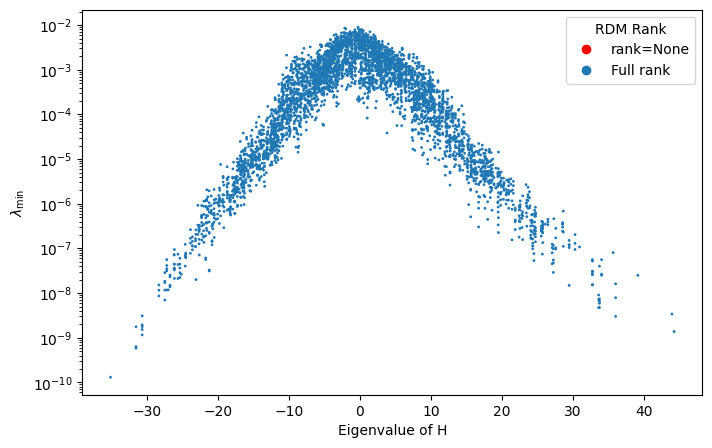

Counts of non-zero eigenvalues of the scarred rdms: []


In [9]:
# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Find indices of non-full-rank points (min_eigenvalue < threshold)
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of non-full-rank points: {red_indices_np}')

# Compute ranks for each non-full-rank RDM
red_ranks = [np.linalg.matrix_rank(rdm) for rdm in min_rdms_np]
if red_ranks:
    min_rank = min(red_ranks)
    other_ranks = sorted(set(red_ranks) - {min_rank})
else:
    min_rank = None
    other_ranks = []

# Save indices for each unique non-full rank (including min_rank)
rank_to_indices = {}
for idx, rank in enumerate(red_ranks):
    if rank not in rank_to_indices:
        rank_to_indices[rank] = []
    rank_to_indices[rank].append(red_indices_np[idx])

print("Indices for each non-full rank:")
for rank, indices in rank_to_indices.items():
    print(f"Rank {rank}: {len(rank_to_indices[rank])} states with indices {indices}")

# Build color list for all points:
# - smallest rank (min_rank) is red
# - other non-full-rank (but not min_rank) are colored by their rank
# - full rank are 'C0'
rank_to_color = {}
color_palette = ['yellow', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray']
for idx, rank in enumerate(other_ranks):
    rank_to_color[rank] = color_palette[idx % len(color_palette)]

point_colors = []
red_counter = 0
for i, y in enumerate(min_eigenvalues_np):
    if y < threshold:
        rank = red_ranks[red_counter]
        if rank == min_rank:
            point_colors.append('red')
        else:
            point_colors.append(rank_to_color[rank])
        red_counter += 1
    else:
        point_colors.append('C0')

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.figure(figsize=(8, 5))
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=point_colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'rank={min_rank}', markerfacecolor='red', markersize=8)
]
for rank in other_ranks:
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w',
               label=f'rank={rank}',
               markerfacecolor=rank_to_color[rank], markersize=8)
    )
legend_elements.append(
    Line2D([0], [0], marker='o', color='w', label='Full rank', markerfacecolor='C0', markersize=8)
)
plt.legend(handles=legend_elements, title="RDM Rank")

plt.show()

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for non-full-rank points
for i, ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

In [10]:
# decide which non-full rank states to analyze
rank_indices_np = rank_to_indices[min_rank]

KeyError: None

In [ ]:
'''# rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')'''

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
C:\Users\camip\AppData\Local\Temp\ipykernel_7300\3775950558.py:42: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(r"$\lambda_{\text{min}}$")


'# rdm - torch\n\nmin_eigenvalues_to = []\nmin_rdms_to = []\nrdm_eigenvalues_to = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)\n    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])\n    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 \n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    min_eigenvalue = torch.min(eigenvalues_traced).item()\n    min_eigenvalues_

In [ ]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(rank_indices_np)) + 1j* np.random.rand(len(rank_indices_np))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, rank_indices_np] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in rank_indices_np])

# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES
rank_eigenvectors_np = np.array([eigenvectors[:, i] for i in rank_indices_np])
rnd_scar = linear_combination_np(random_coeffs, rank_eigenvectors_np)
rnd_scar_entropy = entanglement_entropy(rnd_scar, N // 2, N)
#rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, N // 2, N)
#rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, N // 2, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
#print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
#print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

[0.2674598 +0.12078243j 0.10438746+0.26978028j 0.24506603+0.59167792j
 0.30652435+0.51830046j 0.23273465+0.05745115j]
coeffs norm 0.9999999999999998
4096
Number of zero entries: 3880
Random scar coeffs [0.2674598 +0.12078243j 0.10438746+0.26978028j 0.24506603+0.59167792j
 0.30652435+0.51830046j 0.23273465+0.05745115j]
Entanglement entropy of random scar state: 3.6930995758985037


In [ ]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 4096/4096 [02:26<00:00, 27.97it/s]


Entropies of red points:
Index: 1134, Entropy: 3.5887684686725194
Index: 1135, Entropy: 4.479441530799733
Index: 1136, Entropy: 3.2609806667055823
Index: 1137, Entropy: 4.0299152038197
Index: 1138, Entropy: 4.284536865070566
Random scar entropy: 3.978624817314328


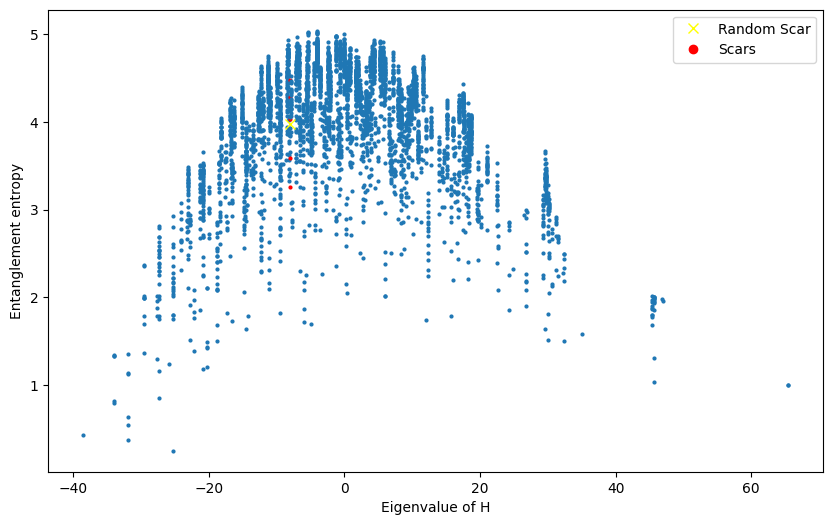

In [ ]:
# Print entropies of red points only
print("Entropies of red points:")
for i in rank_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Color only points with indices in rank_indices_np as red, all others as 'C0'
colors = ['red' if i in rank_indices_np else 'C0' for i in range(len(eigenvalues))]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [ ]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - qutip\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {qutip_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_qutip}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], qutip_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

In [ ]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - torch\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {torch_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_torch}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], torch_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

Entropies of red points:
Index: 1134, Entropy: 3.5887684686725194
Index: 1135, Entropy: 4.479441530799733
Index: 1136, Entropy: 3.2609806667055823
Index: 1137, Entropy: 4.0299152038197
Index: 1138, Entropy: 4.284536865070566
Random scar entropy: 3.978624817314328


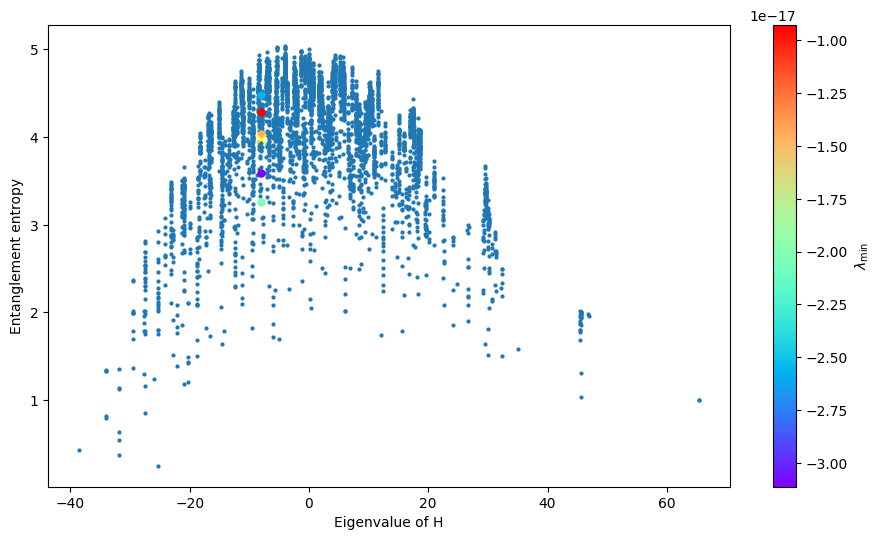

In [ ]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(rank_indices_np)))

# Print entropies of red points only
print("Entropies of red points:")
for i in rank_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Color only points with indices in rank_indices_np as red, all others as 'C0'
colors = ['red' if i in rank_indices_np else 'C0' for i in range(len(eigenvalues))]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(rank_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues_np[idx]):.2e}, Entropy: {numpy_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in rank_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [ ]:
#################### OPTIMAL LINEAR COMBINATION OF SCARS THAT  MINIMIZE/MAXIMIZE EE ##########################

Initial Entropy: 4.358621597290039
Coeffs norm: 1.0
Entropy: 4.358625411987305
Coeffs: [-0.35114437-0.17499682j -0.6990545 -0.27197605j -0.17434107-0.1343667j
  0.15524644+0.14473018j  0.4341923 +0.03748571j]
Coeffs norm: 1.0
Entropy: 4.334747314453125
Coeffs: [-0.35993886-0.16444606j -0.6867544 -0.26110157j -0.18372574-0.14388481j
  0.16469485+0.1542137j   0.44270957+0.0473272j ]
Coeffs norm: 0.99999994
Entropy: 4.3108673095703125
Coeffs: [-0.35384938-0.15477978j -0.6779871 -0.25166398j -0.19409475-0.15412365j
  0.17500722+0.16363437j  0.45354706+0.05741943j]
Coeffs norm: 0.99999994
Entropy: 4.288140296936035
Coeffs: [-0.34640542-0.1451877j  -0.6692136 -0.24248752j -0.2045114 -0.16427973j
  0.18527894+0.17001127j  0.46440697+0.06751463j]
Coeffs norm: 1.0
Entropy: 4.267228126525879
Coeffs: [-0.34026048-0.1357187j  -0.66007775-0.23378596j -0.21486767-0.17407632j
  0.19529085+0.17089576j  0.47499064+0.07755144j]
Coeffs norm: 1.0
Entropy: 4.247977256774902
Coeffs: [-0.34043494-0.12639627j

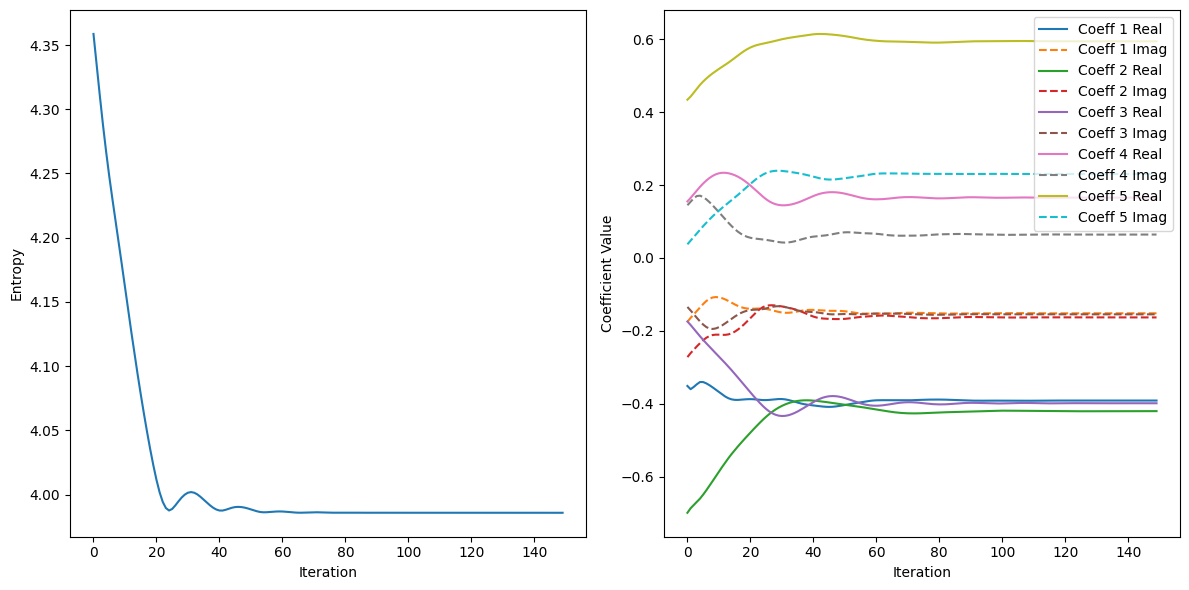

In [ ]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

red_eigenvectors = [torch.tensor(vec, dtype=torch.complex64) for vec in rank_eigenvectors_np]



# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 671, Entropy: 4.618542986070214
Index: 672, Entropy: 3.8988864680020936
Index: 673, Entropy: 4.346557926616162
Index: 674, Entropy: 4.5802979539314395
Index: 675, Entropy: 4.4457152089580845
Index: 676, Entropy: 4.420581499251348
Index: 677, Entropy: 4.163152123676495
Index: 678, Entropy: 4.479112098079631
Index: 679, Entropy: 4.196359350203735
Index: 680, Entropy: 4.565692758235031
Index: 681, Entropy: 3.772813566515375
Index: 682, Entropy: 4.571750544627264
Index: 683, Entropy: 4.400206785935363
Index: 684, Entropy: 4.566720311841189
Index: 685, Entropy: 4.1242653885009215
Index: 686, Entropy: 3.384056175814949
Index: 687, Entropy: 4.613197074981605
Index: 688, Entropy: 4.382603046597582
Index: 689, Entropy: 4.005986383981683
Index: 690, Entropy: 4.212013571609218
Index: 691, Entropy: 4.5023412730274615
Index: 692, Entropy: 4.316142967415865
Index: 693, Entropy: 4.088120532200264
Index: 694, Entropy: 4.537552667639273
Index: 695, Entropy: 4.57711175452

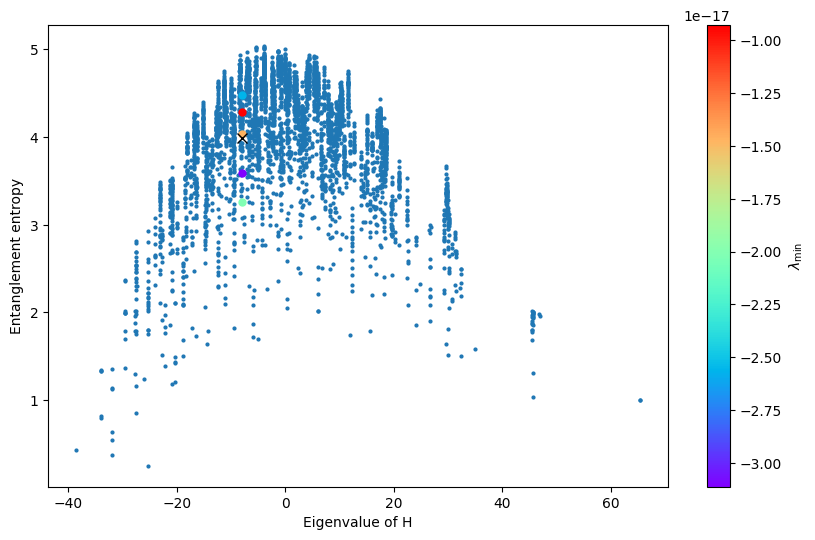

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], rank_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(rank_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Color only points with indices in rank_indices_np as red, all others as 'C0'
colors = ['red' if i in rank_indices_np else 'C0' for i in range(len(eigenvalues))]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(rank_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[rank_indices_np]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in rank_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

Initial coeffs, real tensor([ 0.5603, -0.4463,  0.0956, -0.8960, -0.1895], requires_grad=True)
Initial coeffs imag tensor([ 0.2215,  0.8800,  0.2472, -0.1068,  0.6398], requires_grad=True)
Initial Entropy: 4.22210693359375
Coeffs norm: 1.0
Entropy: 4.222103595733643
Coeffs: [ 0.3431539 +0.13564144j -0.27331865+0.53891975j  0.05852877+0.15140797j
 -0.5487332 -0.06539389j -0.11602914+0.39180607j]
Coeffs norm: 1.0000001
Entropy: 4.246842384338379
Coeffs: [ 0.35335746+0.1457254j  -0.26347044+0.5492362j   0.06856827+0.1414895j
 -0.5390437 -0.07543734j -0.1261018 +0.38202617j]
Coeffs norm: 1.0
Entropy: 4.270503997802734
Coeffs: [ 0.36214858+0.15568262j -0.25347707+0.5592057j   0.07856043+0.13172854j
 -0.52907264-0.08540575j -0.13609642+0.3720098j ]
Coeffs norm: 1.0
Entropy: 4.292998313903809
Coeffs: [ 0.36714423+0.16561264j -0.2436052 +0.5693672j   0.08857705+0.12270216j
 -0.51939404-0.09535537j -0.14614168+0.36212322j]
Coeffs norm: 1.0
Entropy: 4.314308166503906
Coeffs: [ 0.36733106+0.17552

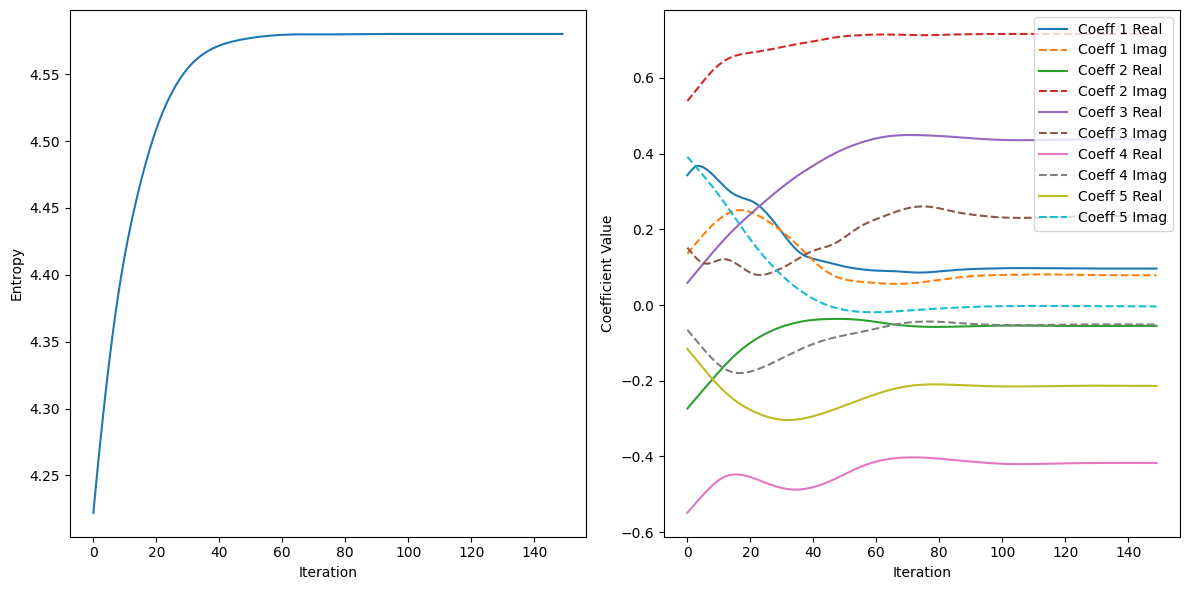

In [ ]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), rank_eigenvectors_np)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, rank_eigenvectors_np)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1134, Entropy: 3.5887684686725194
Index: 1135, Entropy: 4.479441530799733
Index: 1136, Entropy: 3.2609806667055823
Index: 1137, Entropy: 4.0299152038197
Index: 1138, Entropy: 4.284536865070566
Max scar entropy: 4.580023119399518


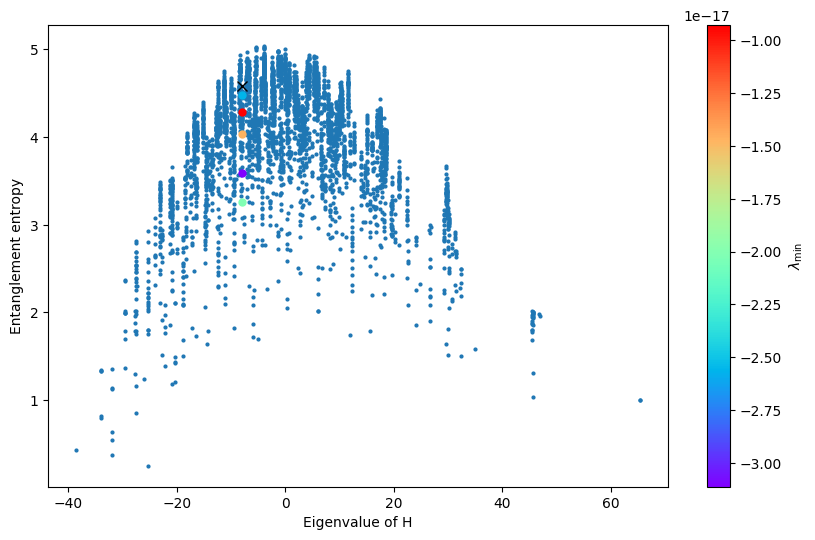

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], rank_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(rank_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in rank_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Color only points with indices in rank_indices_np as red, all others as 'C0'
colors = ['red' if i in rank_indices_np else 'C0' for i in range(len(eigenvalues))]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(rank_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[rank_indices_np]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in rank_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_by_rank[min_rank]): # CHANGE TO RANK CONSIDERED 
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

RDM Index: 0
Null space dimension: 6
Null space basis vectors:
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.43312725e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.47212601e-01]
 [ 9.43312725e-04  0.00000000e+00 -2.90090823e-16  1.31527053e-16
   0.00000000e+00  4.47212601e-01]
 [ 3.14213551e-01  0.00000000e+00  3.24204271e-02 -1.47756864e-02
   0.00000000e+00 -6.62775693e-04]
 [ 9.43312725e-04  0.00000000e+00  1.31974161e-15 -6.00803493e-16
   0.00000000e+00  4.47212601e-01]
 [ 3.14213551e-01  0.00000000e+00  3.24204271e-02 -1.47756864e-02
   0.00000000e+00 -6.62775693e-04]
 [ 3.14213551e-01  0.00000000e+00  3.24204271e-02 -1.47756864e-02
   0.00000000e+00 -6.62775693e-04]
 [ 3.54013038e-02  0.00000000e+00 -2.69304767e-01  1.61931110e-01
   0.00000000e+00 -7.46725389e-05]
 [ 9.43312725e-04  0.00000000e+00 -5.02412901e-17  2.30371651e-17
   0.00000000e+00  4.47212601e-01]
 [ 3.14213551e-01  0.0000000

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_by_rank[min_rank]): # CHANGE TO RANK CONSIDERED
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

RDM Index: 0
Null space dimension: 6
--------------------------------------------------
Repeating rows in the null space basis vectors for RDM 0:
Row 1 is identical to Row 2
Row 1 is identical to Row 4
Row 1 is identical to Row 8
Row 1 is identical to Row 16
Row 2 is identical to Row 4
Row 2 is identical to Row 8
Row 2 is identical to Row 16
Row 3 is identical to Row 5
Row 3 is identical to Row 6
Row 3 is identical to Row 9
Row 3 is identical to Row 10
Row 3 is identical to Row 12
Row 3 is identical to Row 17
Row 3 is identical to Row 18
Row 3 is identical to Row 20
Row 3 is identical to Row 24
Row 4 is identical to Row 8
Row 4 is identical to Row 16
Row 5 is identical to Row 6
Row 5 is identical to Row 9
Row 5 is identical to Row 10
Row 5 is identical to Row 12
Row 5 is identical to Row 17
Row 5 is identical to Row 18
Row 5 is identical to Row 20
Row 5 is identical to Row 24
Row 6 is identical to Row 9
Row 6 is identical to Row 10
Row 6 is identical to Row 12
Row 6 is identical to Row

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(rank_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        #print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

Full Eigenvector 0:
Total Non-Zero Components in Scarred Eigenvector 0: 360
Full Eigenvector 1:
Total Non-Zero Components in Scarred Eigenvector 1: 360
Full Eigenvector 2:
Total Non-Zero Components in Scarred Eigenvector 2: 360
Full Eigenvector 3:
Total Non-Zero Components in Scarred Eigenvector 3: 360
Full Eigenvector 4:
Total Non-Zero Components in Scarred Eigenvector 4: 360


In [ ]:
# Iterate over scarred eigenvectors and print, for each unique nonzero value (by value, tol=1e-12, sign matters),
# the positions and binary representations where it appears
for i, eigenvector in enumerate(rank_eigenvectors_np):
    # Prepare list of (index, value, binary) for nonzero components
    nonzero_info = []
    for index, component in enumerate(eigenvector):
        if np.abs(component) >= 1e-12:
            nonzero_info.append((index, component, index_to_binary(index, N)))
    # Find unique values (within tolerance, sign matters)
    unique_vals = []
    unique_positions = []
    for idx, val, bin_str in nonzero_info:
        found = False
        for u, pos_list in zip(unique_vals, unique_positions):
            if np.abs(val - u) < 1e-12:
                pos_list.append((idx, bin_str))
                found = True
                break
        if not found:
            unique_vals.append(val)
            unique_positions.append([(idx, bin_str)])
    print(f"Eigenvector {i}:")
    print(f"Number of unique nonzero components (tol=1e-12, sign matters): {len(unique_vals)}")
    for uval, pos_list in zip(unique_vals, unique_positions):
        print(f"  Value ≈ {uval:.5g} appears at positions:")
        for idx, bin_str in pos_list:
            print(f"    Index {idx}, Binary {bin_str}")
    print("=" * 50)

Eigenvector 0:
Number of unique nonzero components (tol=1e-12, sign matters): 15
  Value ≈ -0.049442 appears at positions:
    Index 63, Binary 000000111111
    Index 95, Binary 000001011111
    Index 175, Binary 000010101111
    Index 207, Binary 000011001111
    Index 243, Binary 000011110011
    Index 245, Binary 000011110101
    Index 250, Binary 000011111010
    Index 252, Binary 000011111100
    Index 1295, Binary 010100001111
    Index 1520, Binary 010111110000
    Index 1551, Binary 011000001111
    Index 1776, Binary 011011110000
    Index 2319, Binary 100100001111
    Index 2544, Binary 100111110000
    Index 2575, Binary 101000001111
    Index 2800, Binary 101011110000
    Index 3843, Binary 111100000011
    Index 3845, Binary 111100000101
    Index 3850, Binary 111100001010
    Index 3852, Binary 111100001100
    Index 3888, Binary 111100110000
    Index 3920, Binary 111101010000
    Index 4000, Binary 111110100000
    Index 4032, Binary 111111000000
  Value ≈ 0.012661 appe

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

000000000000: 0.0
000000000001: 0.0
000000000010: 0.0
000000000011: 0.0
000000000100: 0.0
000000000101: 0.0
000000000110: 0.0
000000000111: 0.0
000000001000: 0.0
000000001001: 0.0
000000001010: 0.0
000000001011: 0.0
000000001100: 0.0
000000001101: 0.0
000000001110: 0.0
000000001111: 0.0
000000010000: 0.0
000000010001: 0.0
000000010010: 0.0
000000010011: 0.0
000000010100: 0.0
000000010101: 0.0
000000010110: 0.0
000000010111: 0.0
000000011000: 0.0
000000011001: 0.0
000000011010: 0.0
000000011011: 0.0
000000011100: 0.0
000000011101: 0.0
000000011110: 0.0
000000011111: 0.0
000000100000: 0.0
000000100001: 0.0
000000100010: 0.0
000000100011: 0.0
000000100100: 0.0
000000100101: 0.0
000000100110: 0.0
000000100111: 0.0
000000101000: 0.0
000000101001: 0.0
000000101010: 0.0
000000101011: 0.0
000000101100: 0.0
000000101101: 0.0
000000101110: 0.0
000000101111: 0.0
000000110000: 0.0
000000110001: 0.0
000000110010: 0.0
000000110011: 0.0
000000110100: 0.0
000000110101: 0.0
000000110110: 0.0
0000001101

In [ ]:
# check if other states have 360 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")

Total Non-Zero Components in Eigenvector 0: 2048
Total Non-Zero Components in Eigenvector 1: 2048
Total Non-Zero Components in Eigenvector 2: 2048
Total Non-Zero Components in Eigenvector 3: 2048
Total Non-Zero Components in Eigenvector 4: 2048
Total Non-Zero Components in Eigenvector 5: 2048
Total Non-Zero Components in Eigenvector 6: 2016
Total Non-Zero Components in Eigenvector 7: 2048
Total Non-Zero Components in Eigenvector 8: 2048
Total Non-Zero Components in Eigenvector 9: 2048
Total Non-Zero Components in Eigenvector 10: 2048
Total Non-Zero Components in Eigenvector 11: 2048
Total Non-Zero Components in Eigenvector 12: 1970
Total Non-Zero Components in Eigenvector 13: 1970
Total Non-Zero Components in Eigenvector 14: 1970
Total Non-Zero Components in Eigenvector 15: 1970
Total Non-Zero Components in Eigenvector 16: 1970
Total Non-Zero Components in Eigenvector 17: 1970
Total Non-Zero Components in Eigenvector 18: 1970
Total Non-Zero Components in Eigenvector 19: 1970
Total Non-